**Hipótesis:** Es posible predecir el valor de la construcción en una determinada fecha (indice_tiempo) y provincia (alcance_nombre) según la actividad o producto (actividad_producto_nombre).

In [0]:
jdbcHostname = "servidor-tif.database.windows.net"
jdbcDatabase = "AzureSqlDatabase1"
jdbcPort = 1433

dbUser = "*******************"
dbPassword = "***********"

jdbcUrl = f"jdbc:sqlserver://{jdbcHostname}:{jdbcPort};database={jdbcDatabase}"

df = (spark.read
      .format("jdbc")
      .option("url", jdbcUrl)
      .option("dbtable", "dbo.proyecto_datos")
      .option("user", dbUser)
      .option("password", dbPassword)
      .option("driver", "com.microsoft.sqlserver.jdbc.SQLServerDriver")
      .load())

display(df.limit(5))

sector_id,sector_nombre,variable_id,actividad_producto_nombre,indicador,unidad_de_medida,fuente,frecuencia_nombre,cobertura_nombre,alcance_tipo,alcance_id,alcance_nombre,indice_tiempo,valor
24,Construcci�n,387,Art�culos sanitarios de cer�mica,ISAC_desestacionalizada,�ndice base 2004=100,INDEC,Mensual,Nacional,PAIS,200,Argentina,2012-01-01,143.48970592258
24,Construcci�n,387,Art�culos sanitarios de cer�mica,ISAC_desestacionalizada,�ndice base 2004=100,INDEC,Mensual,Nacional,PAIS,200,Argentina,2012-02-01,134.90980700102
24,Construcci�n,387,Art�culos sanitarios de cer�mica,ISAC_desestacionalizada,�ndice base 2004=100,INDEC,Mensual,Nacional,PAIS,200,Argentina,2012-03-01,144.06030425338
24,Construcci�n,387,Art�culos sanitarios de cer�mica,ISAC_desestacionalizada,�ndice base 2004=100,INDEC,Mensual,Nacional,PAIS,200,Argentina,2012-04-01,134.1039395234
24,Construcci�n,387,Art�culos sanitarios de cer�mica,ISAC_desestacionalizada,�ndice base 2004=100,INDEC,Mensual,Nacional,PAIS,200,Argentina,2012-05-01,142.16740349288


In [0]:
print("Conexión segura establecida con:", jdbcHostname)

Conexión segura establecida con: servidor-tif.database.windows.net


**Importo librerías**

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id, col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import pandas as pd

**Limpieza y transformación** 

In [0]:
cols_to_drop = ["sector_id", "sector_nombre", "cobertura_nombre"]
df = df.drop(*[c for c in cols_to_drop if c in df.columns])

# Renombrar columnas
renames = {
    "variable_id": "id_variable",
    "actividad_producto_nombre": "nombre_actividad_producto",
    "frecuencia_nombre": "nombre_frecuencia",
    "alcance_tipo": "tipo_alcance",
    "alcance_id": "id_alcance",
    "alcance_nombre": "nombre_alcance"
}
for old, new in renames.items():
    if old in df.columns:
        df = df.withColumnRenamed(old, new)

# Agregar índice autoincremental
df = df.withColumn("indice", monotonically_increasing_id())

display(df.limit(10))

id_variable,nombre_actividad_producto,indicador,unidad_de_medida,fuente,nombre_frecuencia,tipo_alcance,id_alcance,nombre_alcance,indice_tiempo,valor,indice
387,Art�culos sanitarios de cer�mica,ISAC_desestacionalizada,�ndice base 2004=100,INDEC,Mensual,PAIS,200,Argentina,2012-01-01,143.48970592258,0
387,Art�culos sanitarios de cer�mica,ISAC_desestacionalizada,�ndice base 2004=100,INDEC,Mensual,PAIS,200,Argentina,2012-02-01,134.90980700102,1
387,Art�culos sanitarios de cer�mica,ISAC_desestacionalizada,�ndice base 2004=100,INDEC,Mensual,PAIS,200,Argentina,2012-03-01,144.06030425338,2
387,Art�culos sanitarios de cer�mica,ISAC_desestacionalizada,�ndice base 2004=100,INDEC,Mensual,PAIS,200,Argentina,2012-04-01,134.1039395234,3
387,Art�culos sanitarios de cer�mica,ISAC_desestacionalizada,�ndice base 2004=100,INDEC,Mensual,PAIS,200,Argentina,2012-05-01,142.16740349288,4
387,Art�culos sanitarios de cer�mica,ISAC_desestacionalizada,�ndice base 2004=100,INDEC,Mensual,PAIS,200,Argentina,2012-06-01,144.43518754713,5
387,Art�culos sanitarios de cer�mica,ISAC_desestacionalizada,�ndice base 2004=100,INDEC,Mensual,PAIS,200,Argentina,2012-07-01,149.20910429157,6
387,Art�culos sanitarios de cer�mica,ISAC_desestacionalizada,�ndice base 2004=100,INDEC,Mensual,PAIS,200,Argentina,2012-08-01,158.26207275518,7
387,Art�culos sanitarios de cer�mica,ISAC_desestacionalizada,�ndice base 2004=100,INDEC,Mensual,PAIS,200,Argentina,2012-09-01,126.31749118463,8
387,Art�culos sanitarios de cer�mica,ISAC_desestacionalizada,�ndice base 2004=100,INDEC,Mensual,PAIS,200,Argentina,2012-10-01,142.94282815441,9


**Identifico variables cualitativas y cuantitativas**

In [0]:
cualitativas = ["id_variable", "nombre_actividad_producto", "indicador", "unidad_de_medida",
                "fuente", "nombre_frecuencia", "tipo_alcance", "id_alcance", "nombre_alcance", "indice_tiempo"]
cualitativas = [c for c in cualitativas if c in df.columns]
cuantitativas = ["valor"]

print("Cualitativas:", cualitativas)
print("Cuantitativas:", cuantitativas)

Cualitativas: ['id_variable', 'nombre_actividad_producto', 'indicador', 'unidad_de_medida', 'fuente', 'nombre_frecuencia', 'tipo_alcance', 'id_alcance', 'nombre_alcance', 'indice_tiempo']
Cuantitativas: ['valor']


**Manejo de nulos y tipos**

In [0]:
if 'valor' in df.columns:
    df = df.withColumn("valor", col("valor").cast("double"))

df = df.na.drop(subset=["valor"])
display(df.limit(10))

id_variable,nombre_actividad_producto,indicador,unidad_de_medida,fuente,nombre_frecuencia,tipo_alcance,id_alcance,nombre_alcance,indice_tiempo,valor,indice
387,Art�culos sanitarios de cer�mica,ISAC_desestacionalizada,�ndice base 2004=100,INDEC,Mensual,PAIS,200,Argentina,2012-01-01,143.48970592258,0
387,Art�culos sanitarios de cer�mica,ISAC_desestacionalizada,�ndice base 2004=100,INDEC,Mensual,PAIS,200,Argentina,2012-02-01,134.90980700102,1
387,Art�culos sanitarios de cer�mica,ISAC_desestacionalizada,�ndice base 2004=100,INDEC,Mensual,PAIS,200,Argentina,2012-03-01,144.06030425338,2
387,Art�culos sanitarios de cer�mica,ISAC_desestacionalizada,�ndice base 2004=100,INDEC,Mensual,PAIS,200,Argentina,2012-04-01,134.1039395234,3
387,Art�culos sanitarios de cer�mica,ISAC_desestacionalizada,�ndice base 2004=100,INDEC,Mensual,PAIS,200,Argentina,2012-05-01,142.16740349288,4
387,Art�culos sanitarios de cer�mica,ISAC_desestacionalizada,�ndice base 2004=100,INDEC,Mensual,PAIS,200,Argentina,2012-06-01,144.43518754713,5
387,Art�culos sanitarios de cer�mica,ISAC_desestacionalizada,�ndice base 2004=100,INDEC,Mensual,PAIS,200,Argentina,2012-07-01,149.20910429157,6
387,Art�culos sanitarios de cer�mica,ISAC_desestacionalizada,�ndice base 2004=100,INDEC,Mensual,PAIS,200,Argentina,2012-08-01,158.26207275518,7
387,Art�culos sanitarios de cer�mica,ISAC_desestacionalizada,�ndice base 2004=100,INDEC,Mensual,PAIS,200,Argentina,2012-09-01,126.31749118463,8
387,Art�culos sanitarios de cer�mica,ISAC_desestacionalizada,�ndice base 2004=100,INDEC,Mensual,PAIS,200,Argentina,2012-10-01,142.94282815441,9


**Preparación de features (OneHotEncoder + VectorAssembler)**

In [0]:
cat_cols = [c for c in ['nombre_actividad_producto','fuente','nombre_alcance','nombre_frecuencia'] if c in df.columns]
indexers = [StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid="keep") for c in cat_cols]

encoder = OneHotEncoder(inputCols=[c+"_idx" for c in cat_cols],
                        outputCols=[c+"_ohe" for c in cat_cols],
                        handleInvalid="keep")

df_indexed = df
for idx in indexers:
    df_indexed = idx.fit(df_indexed).transform(df_indexed)
df_indexed = encoder.fit(df_indexed).transform(df_indexed)

assembler = VectorAssembler(
    inputCols=[c+"_ohe" for c in cat_cols],
    outputCol="features",
    handleInvalid="keep"
)
df_assembled = assembler.transform(df_indexed)

display(df_assembled.select("features", "valor").limit(5))

features,valor
"Map(vectorType -> sparse, length -> 53, indices -> List(1, 19, 23, 49), values -> List(1.0, 1.0, 1.0, 1.0))",143.48970592258
"Map(vectorType -> sparse, length -> 53, indices -> List(1, 19, 23, 49), values -> List(1.0, 1.0, 1.0, 1.0))",134.90980700102
"Map(vectorType -> sparse, length -> 53, indices -> List(1, 19, 23, 49), values -> List(1.0, 1.0, 1.0, 1.0))",144.06030425338
"Map(vectorType -> sparse, length -> 53, indices -> List(1, 19, 23, 49), values -> List(1.0, 1.0, 1.0, 1.0))",134.1039395234
"Map(vectorType -> sparse, length -> 53, indices -> List(1, 19, 23, 49), values -> List(1.0, 1.0, 1.0, 1.0))",142.16740349288


**División de datos**

In [0]:
train, test = df_assembled.randomSplit([0.7, 0.3], seed=42)
print("Train:", train.count(), "Test:", test.count())

Train: 9939 Test: 4093


**Entrenamiento del modelo de regresión**

In [0]:
labelCol = "valor"
lr = LinearRegression(featuresCol="features", labelCol="valor")
model = lr.fit(train)
pred_r = model.evaluate(test)

print("RMSE:", pred_r.rootMeanSquaredError)
print("R²:", pred_r.r2)

# Coeficiente de correlación
print("Coeficiente de correlación:", pred_r.predictions.corr('valor', 'prediction'))

RMSE: 667433.5065275206
R²: 0.05988645988919239
Coeficiente de correlación: 0.2744450792243382


**Visualización de resultados**

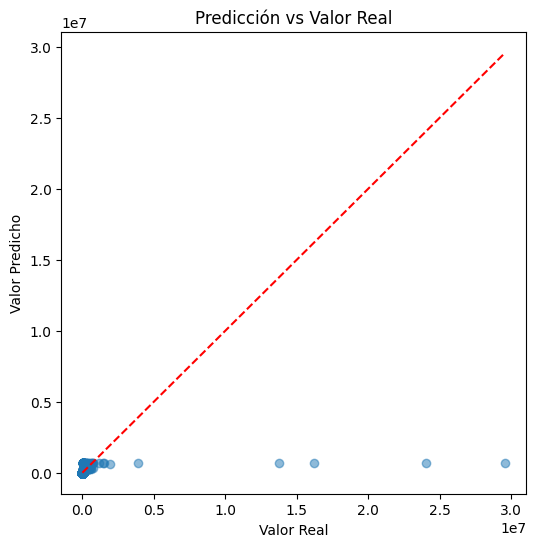

In [0]:
preds_pd = pred_r.predictions.select("valor", "prediction").toPandas()
plt.figure(figsize=(6,6))
plt.scatter(preds_pd["valor"], preds_pd["prediction"], alpha=0.5)
plt.xlabel("Valor Real")
plt.ylabel("Valor Predicho")
plt.title("Predicción vs Valor Real")
plt.plot([preds_pd["valor"].min(), preds_pd["valor"].max()],
         [preds_pd["valor"].min(), preds_pd["valor"].max()],
         color='red', linestyle='--')
plt.show()

**Guardar el modelo**

In [0]:
model.save("/FileStore/modelos/modelo_regresion_construccion")

El modelo de **_Regresión lineal_** fue entrenado para predecir el campo valor a partir de las variables categóricas y temporales.
Los resultados (R² = 0.06, correlación = 0.27) indican una **relación débil** entre las variables independientes y la variable objetivo, por lo que usaré el modelo **_Random Forest_** para ver si mejora la capacidad para predecir.

Para eso tengo que **importar nuevas librerias**:

In [0]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

**Selección y preparación de columnas**

In [0]:
cols_hip1 = ["indice_tiempo", "nombre_actividad_producto", "nombre_alcance", "valor"]
df_rf = df.select([c for c in cols_hip1 if c in df.columns])

**Manejo especial de fecha:** convertir indice_tiempo a STRING

In [0]:
if "indice_tiempo" in df_rf.columns:
    if dict(df_rf.dtypes)["indice_tiempo"] in ("date", "timestamp"):
        df_rf = df_rf.withColumn("indice_tiempo_str", col("indice_tiempo").cast("string"))
        col_indice = "indice_tiempo_str"
    else:
        col_indice = "indice_tiempo"
else:
    col_indice = None

**Construcción dinámica de columnas categóricas a indexar**

In [0]:
categorical_cols = []
if col_indice:
    categorical_cols.append(col_indice)
if "nombre_actividad_producto" in df_rf.columns:
    categorical_cols.append("nombre_actividad_producto")
if "nombre_alcance" in df_rf.columns:
    categorical_cols.append("nombre_alcance")

indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
    for c in categorical_cols
]

pipeline = Pipeline(stages=indexers)
df_rf_indexed = pipeline.fit(df_rf).transform(df_rf)

**VectorAssembler**

In [0]:
feature_cols = [f"{c}_idx" for c in categorical_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

df_rf_final = assembler.transform(df_rf_indexed).select("features", "valor")

**Train/Test**

In [0]:
train_df, test_df = df_rf_final.randomSplit([0.7, 0.3], seed=42)

**Entrenar Random Forest**

In [0]:
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="valor",
    numTrees=120,     # más árboles = más robusto
    maxDepth=14,      # capta no linealidades
    maxBins=512       # clave para variables categóricas grandes  (decia que al menos debía ser 32)
)

model_rf = rf.fit(train_df)

**Predicciones**

In [0]:
predictions = model_rf.transform(test_df)
display(predictions.limit(10))


features,valor,prediction
"Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List())",198.36256395229,12381.996232588692
"Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 4.0))",19362.0,21620.973466201653
"Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 6.0))",97568.0,187073.80157284412
"Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 7.0))",15385.0,20721.898335918842
"Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 11.0))",7400.0,15644.10547237523
"Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 12.0))",9392.0,15829.096598129046
"Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 13.0))",52469.0,46883.0151665709
"Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 17.0))",27023.0,24074.56173834186
"Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 19.0))",20018.0,20067.625990798977
"Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 21.0))",72542.0,154083.22457585516


**Métricas**

In [0]:
eval_rmse = RegressionEvaluator(labelCol="valor", predictionCol="prediction", metricName="rmse")
eval_r2 = RegressionEvaluator(labelCol="valor", predictionCol="prediction", metricName="r2")

rmse_rf = eval_rmse.evaluate(predictions)
r2_rf = eval_r2.evaluate(predictions)

corr_rf = predictions.select(F.corr("valor", "prediction")).collect()[0][0]

print("==== RESULTADOS RANDOM FOREST ====")
print(f"RMSE: {rmse_rf}")
print(f"R²: {r2_rf}")
print(f"Correlación: {corr_rf}")

==== RESULTADOS RANDOM FOREST ====
RMSE: 373449.00216015795
R²: -0.6710895017127674
Correlación: 0.21599801816338451


**Gráfico pandas + matplotlib**

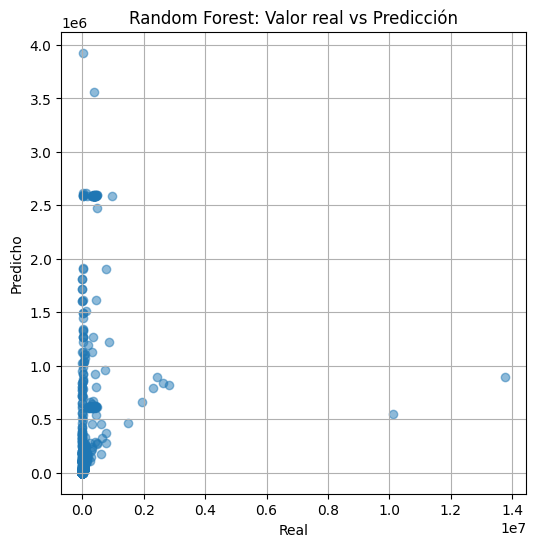

In [0]:
pdf = predictions.select("valor", "prediction").toPandas()

plt.figure(figsize=(6,6))
plt.scatter(pdf["valor"], pdf["prediction"], alpha=0.5)
plt.title("Random Forest: Valor real vs Predicción")
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.grid(True)
plt.show()

Respecto de la Regresión Lineal, **Random Forest** dió un RMSE más bajo (el error absoluto disminuyó), R² bajó y quedó negativo (el modelo no generaliza bien) y la correlación bajó => **Random Forest predice peor que la Regresión lineal** 